# Learning Objectives
By the end of this notebook, students will be able to:

* Implement a quantum variational algorithm to find the ground state of the Schwinger model using Bloqade
* Construct parameterized quantum circuits for variational state preparation
* Design a measurement scheme to estimate Hamiltonian expectation values
* Optimize the variational parameters using classical optimization methods
* Compare variational simulation results with theoretical predictions for strongly correlated systems
* Integrate the variational approach with the broader simulation framework developed for physical model, including Ising model, Hubbard model, Schwinger model, NJL Model, Heiseneberg model, and others.

# 0. Import All the Required Libraries

In [192]:
from bloqade import qasm2
from bloqade.qasm2.emit import QASM2 # the QASM2 target
import numpy as np
import math
import itertools
import warnings
warnings.filterwarnings("ignore")

from pyqrack import QrackSimulator
from bloqade.pyqrack import PyQrack, reg

from bloqade.qasm2.parse import pprint # the QASM2 pretty printer
# import sys
# sys.path.append('/Users/harrywanghc/Developer/2025/2025YaleQHack/src/')
# from PauliHamiltonian import (
#     PauliOp, PauliTerm, PauliHamiltonian
# )

from collections import Counter
from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold

In [193]:
import numpy as np
import scipy.sparse as sparse
from typing import List, Dict, Tuple, Union, Optional
from enum import Enum

class PauliOp(Enum):
    """Enum representation of Pauli operators"""
    I = 0  # Identity
    X = 1  # Pauli X
    Y = 2  # Pauli Y
    Z = 3  # Pauli Z
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    @property
    def matrix(self):
        """Return the matrix representation of the Pauli operator"""
        if self == PauliOp.I:
            return np.array([[1, 0], [0, 1]], dtype=complex)
        elif self == PauliOp.X:
            return np.array([[0, 1], [1, 0]], dtype=complex)
        elif self == PauliOp.Y:
            return np.array([[0, -1j], [1j, 0]], dtype=complex)
        else:  # PauliOp.Z
            return np.array([[1, 0], [0, -1]], dtype=complex)
    
    @property
    def sparse_matrix(self):
        """Return the sparse matrix representation of the Pauli operator"""
        return sparse.csr_matrix(self.matrix)


class PauliTerm:
    """
    Class representing a term in a Pauli Hamiltonian: coefficient * P_1 ⊗ P_2 ⊗ ... ⊗ P_n
    where P_i are Pauli operators (I, X, Y, Z)
    """
    
    def __init__(self, coefficient: complex, operators: Dict[int, PauliOp]):
        """
        Initialize a Pauli term.
        
        Args:
            coefficient: Complex coefficient for the term
            operators: Dictionary mapping qubit indices to Pauli operators
        """
        self.coefficient = coefficient
        self.operators = operators
        
    def __str__(self):
        if not self.operators:
            return f"{self.coefficient}*I"
        
        term_str = f"{self.coefficient}*"
        sorted_qubits = sorted(self.operators.keys())
        
        ops = []
        for q in sorted_qubits:
            ops.append(f"{self.operators[q].name}_{q}")
            
        term_str += " ".join(ops)
        return term_str
    
    def __repr__(self):
        return self.__str__()
    
    def to_matrix(self, n_qubits: int) -> np.ndarray:
        """Convert the Pauli term to a matrix representation."""
        # Start with identity
        result = np.array([[1]], dtype=complex)
        
        for i in range(n_qubits):
            if i in self.operators:
                pauli = self.operators[i].matrix
            else:
                pauli = PauliOp.I.matrix
                
            result = np.kron(result, pauli)
                
        return self.coefficient * result
    
    def to_sparse_matrix(self, n_qubits: int) -> sparse.csr_matrix:
        """Convert the Pauli term to a sparse matrix representation."""
        # Define the basic Pauli matrices
        I = PauliOp.I.sparse_matrix
        X = PauliOp.X.sparse_matrix
        Y = PauliOp.Y.sparse_matrix
        Z = PauliOp.Z.sparse_matrix
        
        pauli_matrices = {
            PauliOp.I: I,
            PauliOp.X: X,
            PauliOp.Y: Y,
            PauliOp.Z: Z
        }
        
        # Start with identity for all qubits
        result = 1
        
        # Build the tensor product
        for i in range(n_qubits):
            if i in self.operators:
                pauli = pauli_matrices[self.operators[i]]
            else:
                pauli = I
                
            if i == 0:
                result = pauli
            else:
                result = sparse.kron(result, pauli, format='csr')
                
        return self.coefficient * result
    
    def get_qubits(self) -> List[int]:
        """Get the list of qubits this term operates on."""
        return list(self.operators.keys())
    
    def commutes_with(self, other: 'PauliTerm') -> bool:
        """Check if this Pauli term commutes with another term."""
        # Two Pauli terms commute if they have an even number of positions
        # where they differ and neither is the identity
        count_anticommuting_positions = 0
        
        # Check all positions where both terms have operators
        common_qubits = set(self.operators.keys()) & set(other.operators.keys())
        
        for qubit in common_qubits:
            op1 = self.operators[qubit]
            op2 = other.operators[qubit]
            
            # Identity commutes with everything
            if op1 == PauliOp.I or op2 == PauliOp.I:
                continue
                
            # Check if these operators anticommute
            # X, Y, Z all anticommute with each other
            if op1 != op2:
                count_anticommuting_positions += 1
                
        # If the number of anticommuting positions is even, the terms commute
        return count_anticommuting_positions % 2 == 0


class PauliHamiltonian:
    """Class representing a Hamiltonian as a sum of Pauli terms."""
    
    def __init__(self, terms: Optional[List[PauliTerm]] = None):
        """
        Initialize a Pauli Hamiltonian.
        
        Args:
            terms: List of PauliTerm objects
        """
        self.terms = terms or []
        
    def add_term(self, term: PauliTerm):
        """Add a term to the Hamiltonian."""
        self.terms.append(term)
        return self
    
    def __str__(self):
        if not self.terms:
            return "0"
        
        return " + ".join(str(term) for term in self.terms)
    
    def __repr__(self):
        return self.__str__()
    
    def to_sparse_matrix(self, n_qubits: int = None) -> sparse.csr_matrix:
        """Convert the Hamiltonian to a sparse matrix representation."""
        if n_qubits is None:
            n_qubits = self.get_n_qubits()

        if not self.terms:
            dim = 2**n_qubits
            return sparse.csr_matrix((dim, dim), dtype=complex)
        
        result = self.terms[0].to_sparse_matrix(n_qubits)
        
        for term in self.terms[1:]:
            result += term.to_sparse_matrix(n_qubits)
            
        return result
    
    def to_matrix(self, n_qubits: int = None) -> sparse.csr_matrix:
        """Convert the Hamiltonian to a sparse matrix representation."""
        if n_qubits is None:
            n_qubits = self.get_n_qubits()
            
        # Convert the Hamiltonian to a sparse matrix first
        sparse_matrix = self.to_sparse_matrix(n_qubits)
    
        # Convert to dense matrix
        return sparse_matrix.toarray()
    
    def get_all_qubits(self) -> List[int]:
        """Get a sorted list of all qubits this Hamiltonian operates on."""
        qubits = set()
        for term in self.terms:
            qubits.update(term.get_qubits())
        return sorted(list(qubits))
    
    def get_n_qubits(self) -> int:
        """Get the number of qubits in the system based on highest qubit index."""
        if not self.terms:
            return 0
        
        all_qubits = self.get_all_qubits()
        if not all_qubits:
            return 0
        
        return max(all_qubits) + 1
    
    def group_terms_by_type(self) -> Dict[str, 'PauliHamiltonian']:
        """
        Group Hamiltonian terms by their Pauli type.
        
        Returns:
            Dictionary mapping term types ('X', 'Y', 'Z', 'mixed') to sub-Hamiltonians
        """
        grouped = {
            'X': PauliHamiltonian(),
            'Y': PauliHamiltonian(),
            'Z': PauliHamiltonian(),
            'mixed': PauliHamiltonian()
        }
        
        for term in self.terms:
            # Skip terms with coefficient 0
            if abs(term.coefficient) < 1e-10:
                continue
                
            # Check if this term has operators of only one type
            op_types = set(op for op in term.operators.values())
            
            if len(op_types) == 1:
                op_type = next(iter(op_types))
                if op_type == PauliOp.X:
                    grouped['X'].add_term(term)
                elif op_type == PauliOp.Y:
                    grouped['Y'].add_term(term)
                elif op_type == PauliOp.Z:
                    grouped['Z'].add_term(term)
                else:  # Identity terms
                    # Add identity terms to all groups since they commute with everything
                    for group in grouped.values():
                        group.add_term(term)
            else:
                # Mixed term
                grouped['mixed'].add_term(term)
                
        return grouped
    
    # Add this method to the PauliHamiltonian class in PauliHamiltonian.py

    def simplify(self):
        """
        Simplify the Hamiltonian by combining like terms and removing negligible terms.
        
        Returns:
            A new simplified PauliHamiltonian object
        """
        # Create a dictionary to group terms by their operators
        grouped_terms = {}
        
        for term in self.terms:
            # Create a unique key for each term based on its operators
            key_parts = []
            
            # Sort by qubit index for consistent ordering
            for qubit in sorted(term.operators.keys()):
                op = term.operators[qubit]
                key_parts.append(f"{op.name}_{qubit}")
            
            # Create the key - empty string means identity operator
            key = " ".join(key_parts) if key_parts else "I"
            
            # Add coefficient to the appropriate group
            if key in grouped_terms:
                grouped_terms[key] += term.coefficient
            else:
                grouped_terms[key] = term.coefficient
        
        # Create new PauliHamiltonian with simplified terms
        simplified = PauliHamiltonian()
        
        for key, coefficient in grouped_terms.items():
            # Skip terms with near-zero coefficients
            if abs(coefficient) < 1e-10:
                continue
            
            # Parse the key to reconstruct operators dictionary
            operators = {}
            
            # Handle the identity case
            if key == "I":
                term = PauliTerm(coefficient, {})
            else:
                # Split the key into operator_qubit pairs
                parts = key.split()
                for part in parts:
                    op_name, qubit_str = part.split('_')
                    qubit = int(qubit_str)
                    
                    # Map the name back to a PauliOp
                    if op_name == "X":
                        op = PauliOp.X
                    elif op_name == "Y":
                        op = PauliOp.Y
                    elif op_name == "Z":
                        op = PauliOp.Z
                    else:  # Identity
                        op = PauliOp.I
                    
                    operators[qubit] = op
                
                term = PauliTerm(coefficient, operators)
            
            # Add the simplified term to the new Hamiltonian
            simplified.add_term(term)
        
        return simplified
    
    def commuting_groups(self) -> List['PauliHamiltonian']:
        """
        Group the Hamiltonian terms into sets of mutually commuting terms.
        
        Returns:
            List of PauliHamiltonian objects, each containing mutually commuting terms
        """
        if not self.terms:
            return []
            
        # Start with each term in its own group
        groups = []
        for term in self.terms:
            groups.append(PauliHamiltonian([term]))
            
        # Try to merge groups
        i = 0
        while i < len(groups):
            j = i + 1
            while j < len(groups):
                # Check if all terms in group i commute with all terms in group j
                all_commute = True
                
                for term_i in groups[i].terms:
                    for term_j in groups[j].terms:
                        if not term_i.commutes_with(term_j):
                            all_commute = False
                            break
                    if not all_commute:
                        break
                        
                if all_commute:
                    # Merge group j into group i
                    groups[i].terms.extend(groups[j].terms)
                    groups.pop(j)
                else:
                    j += 1
                    
            i += 1
            
        return groups


# 1. Create the SchwingerModel Hamiltonian

In [194]:
def create_schwinger_hamiltonian(N: int, m: float = 1.0, g: float = 1.0, a: float = 1.0) -> PauliHamiltonian:
    """
    Create the Schwinger Hamiltonian for 1+1D quantum electrodynamics.
    
    Args:
        N: Number of lattice sites
        m: Mass parameter
        g: Coupling constant
        a: Lattice spacing
    
    Returns:
        PauliHamiltonian representing the Schwinger model
    """
    ham = PauliHamiltonian()
    
    # Hopping terms (XX and YY interactions)
    for n in range(1, N):
        # XX terms: (1/4a) * X_{n-1} X_n
        ham.add_term(PauliTerm(1/(4*a), {n-1: PauliOp.X, n: PauliOp.X}))
        
        # YY terms: (1/4a) * Y_{n-1} Y_n
        ham.add_term(PauliTerm(1/(4*a), {n-1: PauliOp.Y, n: PauliOp.Y}))
    
    # Mass terms: (-1)^n * (m/2) * Z_{n-1}
    for n in range(1, N+1):
        coefficient = ((-1)**n) * (m/2)
        ham.add_term(PauliTerm(coefficient, {n-1: PauliOp.Z}))
    
    # Electric field energy terms
    c_ga = (a * g**2 / 2) * (1/4)  # Common coefficient
    
    for n in range(1, N):
        # First part: Identity terms
        for j in range(1, n+1):
            # Identity term: c_ga * 2 * I_{j-1}
            ham.add_term(PauliTerm(c_ga * 2, {}))  # Empty dict means identity on all qubits
            
            # Z term: c_ga * 2 * (-1)^j * Z_{j-1}
            coefficient = c_ga * 2 * ((-1)**j)
            ham.add_term(PauliTerm(coefficient, {j-1: PauliOp.Z}))
        
        # Second part: ZZ and mixed terms
        for l in range(1, n+1):
            for m_idx in range(1, l):
                # ZZ term: c_ga * 2 * Z_{l-1} Z_{m-1}
                ham.add_term(PauliTerm(c_ga * 2, {l-1: PauliOp.Z, m_idx-1: PauliOp.Z}))
                
                # Identity term: c_ga * 2 * (-1)^(l+m) * I
                coefficient = c_ga * 2 * ((-1)**(l+m_idx))
                ham.add_term(PauliTerm(coefficient, {}))
                
                # Z term on m: c_ga * 2 * (-1)^l * Z_{m-1}
                coefficient = c_ga * 2 * ((-1)**l)
                ham.add_term(PauliTerm(coefficient, {m_idx-1: PauliOp.Z}))
                
                # Z term on l: c_ga * 2 * (-1)^m * Z_{l-1}
                coefficient = c_ga * 2 * ((-1)**m_idx)
                ham.add_term(PauliTerm(coefficient, {l-1: PauliOp.Z}))
    
    return ham.simplify()

In [195]:
H_test = create_schwinger_hamiltonian(4, 1, 1, 1)
print(H_test)
H_matrix = H_test.to_matrix()
eigs = np.linalg.eigvalsh(H_matrix)
print("Eigenvalues:", min(eigs))


0.25*X_0 X_1 + 0.25*Y_0 Y_1 + 0.25*X_1 X_2 + 0.25*Y_1 Y_2 + 0.25*X_2 X_3 + 0.25*Y_2 Y_3 + -1.0*Z_0 + 0.25*Z_1 + -0.75*Z_2 + 0.5*Z_3 + 1.0*I + 0.5*Z_0 Z_1 + 0.25*Z_0 Z_2 + 0.25*Z_1 Z_2
Eigenvalues: -2.2765645864303945


# 2. Prepare the Ansatz

In [196]:
@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass

In [197]:
def ansatz_no_ham(params, n_qubits: int, reps: int, skip_final_rotation_layer=False):
    # entangle_pairs = list(itertools.combinations(range(n_qubits), 2))
    
    @extended_opt
    def ansatz():
        
        qreg = qasm2.qreg(n_qubits)
        creg = qasm2.creg(n_qubits)
        for r in range(reps):
            # Apply the rotation blocks
            for i in range(n_qubits):
                qasm2.rx(qreg[i], params[r, i, 0])
                qasm2.ry(qreg[i], params[r, i, 1])
                qasm2.rz(qreg[i], params[r, i, 2])
            if r < reps:
                for j in range(n_qubits):
                    for k in range(j+1, n_qubits):
                        qasm2.cx(qreg[j], qreg[k])
                        qasm2.cz(qreg[j], qreg[k])
        # Apply the final rotation layer
        if not skip_final_rotation_layer:
            for i in range(n_qubits):
                qasm2.rx(qreg[i], params[-1, i, 0])
                qasm2.ry(qreg[i], params[-1, i, 1])
                qasm2.rz(qreg[i], params[-1, i, 2])
        # Hamiltonian layer: No Hamiltonian layer in this ansatz
        for i in range(n_qubits):
            qasm2.measure(qreg[i],creg[i])

        return creg
    
    return ansatz

In [ ]:
# test this with params.
num_qubits=4
layers=1
init_params = np.random.random((layers+1, num_qubits, 3))*2*np.pi

# 3. Run the simulation

## 3.1 Run Plain Simulation with no Hamiltonian and no Variational

In [198]:
kernel = ansatz_no_ham(init_params, num_qubits, layers)

In [199]:
device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
results = device.multi_run(kernel, _shots=100)

def to_bitstrings(results):
        return Counter(map(lambda result:"".join(map(str, result)), results))
    
counts = to_bitstrings(results)
counts



Counter({'1011': 21,
         '0111': 12,
         '0110': 12,
         '1000': 8,
         '0011': 8,
         '1010': 7,
         '1100': 6,
         '0100': 6,
         '0001': 5,
         '0101': 4,
         '1001': 3,
         '1111': 3,
         '1101': 2,
         '0000': 2,
         '0010': 1})

In [200]:
def counter_measure(counts, operators=None):
    """
    Calculate the expectation value of a multi-qubit Z operator from measurement counts.
    
    Args:
        counts: Counter object with bitstrings as keys and counts as values
        operators: List of operator indices to consider (defaults to all qubits)
                    For example, [0, 2, 3] would measure Z⊗I⊗Z⊗Z
    
    Returns:
        The expectation value of the Z operator product
    """
    total_counts = sum(counts.values())
    
    # Determine the number of qubits from the first bitstring
    n_qubits = len(next(iter(counts.keys())))
    
    # If no specific operators provided, use all qubits
    if operators is None:
        operators = list(range(n_qubits))
    
    # Calculate expectation value
    expectation = 0.0
    for bitstring, count in counts.items():
        # Convert each bit to ±1 (0→+1, 1→-1) and multiply
        # only for the specified qubits
        z_product = 1
        for idx in operators:
            if idx < len(bitstring):  # Ensure the index is valid
                z_product *= (-1)**int(bitstring[idx])
        
        # Add to expectation, weighted by count
        expectation += z_product * count
    
    # Normalize by total counts
    return expectation / total_counts

# Measure ZZZZ (all qubits)
zzzz_expectation = counter_measure(counts)
print(f"ZZZZ expectation value: {zzzz_expectation}")

ZZZZ expectation value: -0.1


In [201]:
for terms in H_test.terms:
    print(terms.coefficient)
    print(terms.operators)

0.25
{0: X, 1: X}
0.25
{0: Y, 1: Y}
0.25
{1: X, 2: X}
0.25
{1: Y, 2: Y}
0.25
{2: X, 3: X}
0.25
{2: Y, 3: Y}
-1.0
{0: Z}
0.25
{1: Z}
-0.75
{2: Z}
0.5
{3: Z}
1.0
{}
0.5
{0: Z, 1: Z}
0.25
{0: Z, 2: Z}
0.25
{1: Z, 2: Z}


## 3.2 Run the simulation with the the Coded Schwinger Model Hamiltonian and Variational Layer

In [202]:
def ansatz_with_ham_exp(params, hamiltonian, n_qubits: int, reps: int, skip_final_rotation_layer=False, shots=100):
    # entangle_pairs = list(itertools.combinations(range(n_qubits), 2))
    reshaped_params = params.reshape(reps+1, n_qubits, 3)
    params = reshaped_params
    # for each subterm in hamiltonian, we apply the corresponding gates.
    # That is, if we have a term.operator like X_0 Y_1, we apply the corresponding gates: 
    # X_0: add hadamard to qubit 0 to make it Z.
    # Y_1: add Sdg to qubit 1 and then H to make it Z.
    # Z_2: No change to qubit 2.
    # I_3: No change to qubit 3. If it's empty, then it's Identity. We do nothing
    # The Hamiltonian is a sum of terms, so we can apply each term in parallel.

    expectation_value = 0

    coeff_list = [terms.coefficient for terms in hamiltonian.terms]
    
    # 0/13
    def sub_ansatz0():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {0: X, 1: X}
            qasm2.h(qreg[0])
            qasm2.h(qreg[1])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    
    sub_kernel0 = sub_ansatz0()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results0 = device.multi_run(sub_kernel0, _shots=shots)
    counts0 = to_bitstrings(results0)
    expectation0 = counter_measure(counts0, operators=[0, 1])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[0] * expectation0 

    # 1/13
    def sub_ansatz1():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {0: Y, 1: Y}
            qasm2.sdg(qreg[0])
            qasm2.h(qreg[0])
            qasm2.sdg(qreg[1])
            qasm2.h(qreg[1])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    
    sub_kernel1 = sub_ansatz1()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results1 = device.multi_run(sub_kernel1, _shots=shots)
    counts1 = to_bitstrings(results1)
    expectation1 = counter_measure(counts1, operators=[0, 1])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[1] * expectation1

    # 2/13
    def sub_ansatz2():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {1: X, 2: X}
            qasm2.h(qreg[1])
            qasm2.h(qreg[2])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel2 = sub_ansatz2()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results2 = device.multi_run(sub_kernel2, _shots=shots)
    counts2 = to_bitstrings(results2)
    expectation2 = counter_measure(counts2, operators=[1, 2])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[2] * expectation2
    
    # 3/13 {1: Y, 2: Y}
    def sub_ansatz3():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {1: Y, 2: Y}
            qasm2.sdg(qreg[1])
            qasm2.h(qreg[1])
            qasm2.sdg(qreg[2])
            qasm2.h(qreg[2])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel3 = sub_ansatz3()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results3 = device.multi_run(sub_kernel3, _shots=shots)
    counts3 = to_bitstrings(results3)
    expectation3 = counter_measure(counts3, operators=[1, 2])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[3] * expectation3

    # 4/13 {2: X, 3: X}
    def sub_ansatz4():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {2: X, 3: X}
            qasm2.h(qreg[2])
            qasm2.h(qreg[3])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel4 = sub_ansatz4()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results4 = device.multi_run(sub_kernel4, _shots=shots)
    counts4 = to_bitstrings(results4)
    expectation4 = counter_measure(counts4, operators=[2, 3])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[4] * expectation4

    # 5/13 {2: Y, 3: Y}
    def sub_ansatz5():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {2: Y, 3: Y}
            qasm2.sdg(qreg[2])
            qasm2.h(qreg[2])
            qasm2.sdg(qreg[3])
            qasm2.h(qreg[3])
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel5 = sub_ansatz5()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results5 = device.multi_run(sub_kernel5, _shots=shots)
    counts5 = to_bitstrings(results5)
    expectation5 = counter_measure(counts5, operators=[2, 3])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[5] * expectation5

    # 6/13 {0: Z}
    def sub_ansatz6():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {0: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel6 = sub_ansatz6()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results6 = device.multi_run(sub_kernel6, _shots=shots)
    counts6 = to_bitstrings(results6)
    expectation6 = counter_measure(counts6, operators=[0])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[6] * expectation6

    # 7/13 {1: Z}
    def sub_ansatz7():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {1: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel7 = sub_ansatz7()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results7 = device.multi_run(sub_kernel7, _shots=shots)
    counts7 = to_bitstrings(results7)
    expectation7 = counter_measure(counts7, operators=[1])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[7] * expectation7

    # 8/13 {2: Z}
    def sub_ansatz8():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {2: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel8 = sub_ansatz8()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results8 = device.multi_run(sub_kernel8, _shots=shots)
    counts8 = to_bitstrings(results8)
    expectation8 = counter_measure(counts8, operators=[2])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[8] * expectation8

    # 9/13 {3: Z}   
    def sub_ansatz9():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {3: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel9 = sub_ansatz9()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results9 = device.multi_run(sub_kernel9, _shots=shots)
    counts9 = to_bitstrings(results9)
    expectation9 = counter_measure(counts9, operators=[3])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[9] * expectation9

    # 10/13 {}
    expectation_value += coeff_list[10] * 1

    # 11/13 {0: Z, 1: Z}
    def sub_ansatz11():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {0: Z, 1: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel11 = sub_ansatz11()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results11 = device.multi_run(sub_kernel11, _shots=shots)
    counts11 = to_bitstrings(results11)
    expectation11 = counter_measure(counts11, operators=[0, 1])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[11] * expectation11

    # 12/13 {0: Z, 2: Z}
    def sub_ansatz12():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {0: Z, 2: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel12 = sub_ansatz12()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results12 = device.multi_run(sub_kernel12, _shots=shots)
    counts12 = to_bitstrings(results12)
    expectation12 = counter_measure(counts12, operators=[0, 2])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[12] * expectation12

    # 13/13 {1: Z, 2: Z}
    def sub_ansatz13():

        @extended_opt
        def ansatz():
            
            qreg = qasm2.qreg(n_qubits)
            creg = qasm2.creg(n_qubits)
            for r in range(reps):
                # Apply the rotation blocks
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[r, i, 0])
                    qasm2.ry(qreg[i], params[r, i, 1])
                    qasm2.rz(qreg[i], params[r, i, 2])
                if r < reps:
                    for j in range(n_qubits):
                        for k in range(j+1, n_qubits):
                            qasm2.cx(qreg[j], qreg[k])
                            qasm2.cz(qreg[j], qreg[k])
            # Apply the final rotation layer
            if not skip_final_rotation_layer:
                for i in range(n_qubits):
                    qasm2.rx(qreg[i], params[-1, i, 0])
                    qasm2.ry(qreg[i], params[-1, i, 1])
                    qasm2.rz(qreg[i], params[-1, i, 2])
            # Hamiltonian layer: {1: Z, 2: Z}
            # Measurement
            for i in range(n_qubits):
                qasm2.measure(qreg[i],creg[i])

            return creg
        
        return ansatz
    sub_kernel13 = sub_ansatz13()
    device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
    results13 = device.multi_run(sub_kernel13, _shots=shots)
    counts13 = to_bitstrings(results13)
    expectation13 = counter_measure(counts13, operators=[1, 2])
    # Multiply by the coefficient of the term
    expectation_value += coeff_list[13] * expectation13

    return expectation_value

In [203]:
# test this with params.
num_qubits=4
layers=1
init_params = np.random.random((layers+1, num_qubits, 3))*2*np.pi

In [204]:
e_val = ansatz_with_ham_exp(H_test, init_params, num_qubits, layers, shots=300)

AttributeError: 'PauliHamiltonian' object has no attribute 'reshape'

In [ ]:
print(e_val)

1.2699999999999998


In [ ]:
from scipy.optimize import minimize

In [ ]:
def vqe(hamiltonian, shots=300, maxiter = 300, random_seed = 42, verbose = False):
    # helper func
    exp_val_list = []
    # def callback(num_eval, params, f_eval, step, acc):
    def callback(params):
        exp_val = ansatz_with_ham_exp(params, hamiltonian, num_qubits, layers, shots=shots)
        exp_val_list.append(exp_val)
        if verbose == True: print(f"step {len(exp_val_list):>4}:  <H> = {exp_val:>6.3f}")

    def minimize_free_energy(params):
        value_to_minimize = ansatz_with_ham_exp(params, hamiltonian, num_qubits, layers, shots=shots)
        return value_to_minimize
    
    np.random.seed(random_seed)
    inital_params = np.random.random((layers+1, num_qubits, 3))*2*np.pi
    flatten_initial_params = inital_params.flatten()
    opt = minimize(minimize_free_energy, flatten_initial_params, method='COBYLA', callback=callback, options={'maxiter': maxiter})

    return opt, exp_val_list

In [ ]:
vqe_result, exp_val_list = vqe(H_test, shots=500, maxiter=300, random_seed=42, verbose=True)

step    1:  <H> =  1.129
step    2:  <H> =  1.410
step    3:  <H> =  1.068
step    4:  <H> =  0.916
step    5:  <H> =  0.825
step    6:  <H> =  0.850
step    7:  <H> = -0.037
step    8:  <H> = -0.138
step    9:  <H> =  0.549
step   10:  <H> =  0.007
step   11:  <H> = -0.134
step   12:  <H> =  0.028
step   13:  <H> =  0.288
step   14:  <H> = -0.535
step   15:  <H> = -0.268
step   16:  <H> = -0.704
step   17:  <H> = -0.208
step   18:  <H> = -0.446
step   19:  <H> = -0.604
step   20:  <H> = -0.409
step   21:  <H> = -0.645
step   22:  <H> = -0.724
step   23:  <H> = -0.838
step   24:  <H> = -0.912
step   25:  <H> = -0.645
step   26:  <H> = -0.796
step   27:  <H> = -0.803
step   28:  <H> = -0.900
step   29:  <H> = -0.783
step   30:  <H> = -0.825
step   31:  <H> = -0.303
step   32:  <H> = -1.138
step   33:  <H> = -0.734
step   34:  <H> = -0.592
step   35:  <H> = -0.571
step   36:  <H> = -1.286
step   37:  <H> = -1.575
step   38:  <H> = -1.582
step   39:  <H> = -0.600
step   40:  <H> = -1.694


AttributeError: minimize

# 4. Plot the results

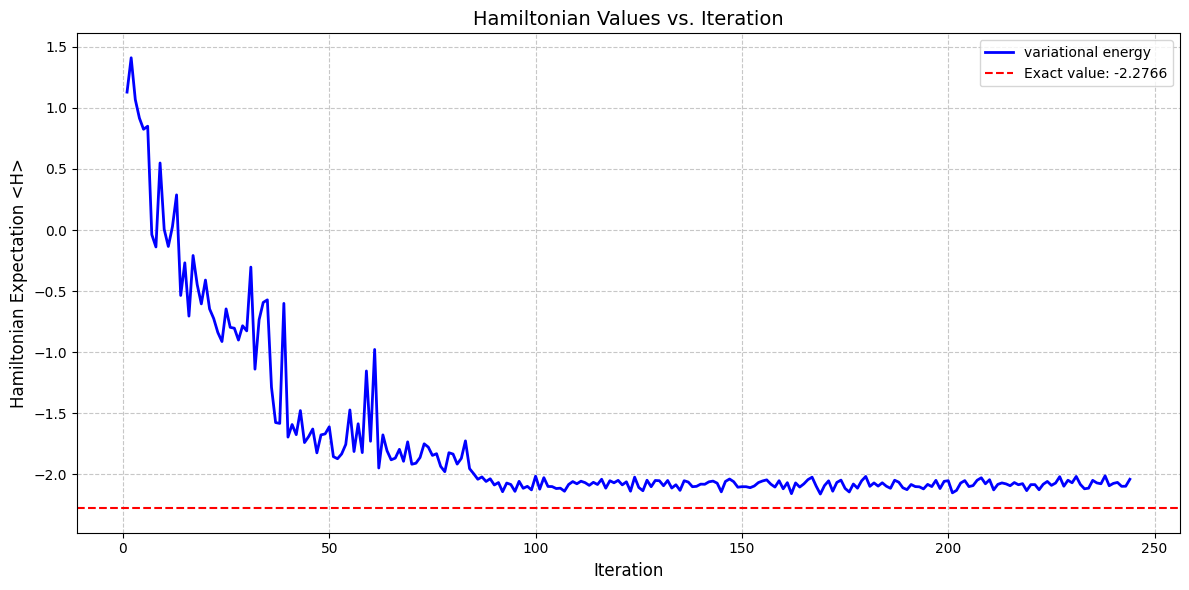

In [ ]:
import matplotlib.pyplot as plt

# Hamiltonian values
hamiltonian_values = [
    1.129, 1.410, 1.068, 0.916, 0.825, 0.850, -0.037, -0.138, 0.549, 0.007,
    -0.134, 0.028, 0.288, -0.535, -0.268, -0.704, -0.208, -0.446, -0.604, -0.409,
    -0.645, -0.724, -0.838, -0.912, -0.645, -0.796, -0.803, -0.900, -0.783, -0.825,
    -0.303, -1.138, -0.734, -0.592, -0.571, -1.286, -1.575, -1.582, -0.600, -1.694,
    -1.591, -1.674, -1.477, -1.739, -1.690, -1.628, -1.823, -1.676, -1.668, -1.610,
    -1.854, -1.871, -1.832, -1.754, -1.472, -1.812, -1.585, -1.821, -1.153, -1.728,
    -0.977, -1.947, -1.676, -1.806, -1.880, -1.866, -1.794, -1.892, -1.733, -1.916,
    -1.908, -1.861, -1.749, -1.776, -1.844, -1.830, -1.934, -1.977, -1.822, -1.833,
    -1.915, -1.868, -1.725, -1.952, -1.994, -2.039, -2.020, -2.057, -2.035, -2.086,
    -2.066, -2.141, -2.070, -2.082, -2.138, -2.056, -2.113, -2.097, -2.126, -2.014,
    -2.120, -2.026, -2.098, -2.099, -2.115, -2.112, -2.137, -2.082, -2.058, -2.076,
    -2.055, -2.067, -2.089, -2.064, -2.082, -2.039, -2.112, -2.051, -2.068, -2.048,
    -2.085, -2.060, -2.137, -2.022, -2.106, -2.133, -2.047, -2.100, -2.049, -2.051,
    -2.092, -2.049, -2.111, -2.084, -2.130, -2.051, -2.062, -2.100, -2.097, -2.079,
    -2.080, -2.060, -2.054, -2.071, -2.142, -2.057, -2.037, -2.059, -2.104, -2.100,
    -2.100, -2.108, -2.094, -2.066, -2.053, -2.044, -2.079, -2.103, -2.051, -2.117,
    -2.067, -2.157, -2.069, -2.103, -2.077, -2.042, -2.022, -2.096, -2.160, -2.091,
    -2.052, -2.137, -2.065, -2.046, -2.114, -2.143, -2.078, -2.112, -2.052, -2.016,
    -2.097, -2.069, -2.095, -2.068, -2.096, -2.113, -2.047, -2.063, -2.109, -2.124,
    -2.082, -2.099, -2.101, -2.118, -2.081, -2.099, -2.048, -2.115, -2.056, -2.051,
    -2.150, -2.130, -2.070, -2.050, -2.099, -2.091, -2.047, -2.027, -2.076, -2.043,
    -2.126, -2.081, -2.069, -2.077, -2.092, -2.066, -2.084, -2.075, -2.132, -2.083,
    -2.083, -2.125, -2.080, -2.057, -2.089, -2.070, -2.018, -2.096, -2.047, -2.068,
    -2.016, -2.081, -2.117, -2.112, -2.048, -2.069, -2.076, -2.011, -2.092, -2.073,
    -2.065, -2.097, -2.096, -2.039
]

# Target value
target_value = -2.2765645864303945

# Create iterations list (1-indexed to match output)
iterations = list(range(1, len(hamiltonian_values) + 1))

# Set up the figure and axes with a specific size
plt.figure(figsize=(12, 6))

# Plot Hamiltonian values
plt.plot(iterations, hamiltonian_values, 'b-', label='variational energy', linewidth=2)

# Add reference line for target value
plt.axhline(y=target_value, color='r', linestyle='--', label=f'Exact value: {target_value:.4f}')

# Set labels and title
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Hamiltonian Expectation <H>', fontsize=12)
plt.title('Hamiltonian Values vs. Iteration', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits with some padding
plt.ylim(min(target_value, min(hamiltonian_values)) - 0.2, max(hamiltonian_values) + 0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()